In [1]:
# %pip install -U ray ray[debug] ray[dashboard]

In [2]:
# May need to restart kernel
import ray
import time


# This is pretty unreliable, may need to manually retry
def restart_ray():
    ray.shutdown()
    ray.init(object_store_memory=32e9)  # is this ignored? consumes 110+ GB
    
restart_ray()    

2020-06-25 23:58:10,664	INFO resource_spec.py:212 -- Starting Ray with 27.34 GiB memory available for workers and up to 29.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-25 23:58:10,904	WARNING services.py:923 -- Redis failed to start, retrying now.
2020-06-25 23:58:11,149	INFO services.py:1165 -- View the Ray dashboard at localhost:8265


## Matrix Multiplication

In [3]:
import numpy as np


def local_matmul(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """A(l, m) x B(m, n) = C(l, n)"""
    assert a.shape[1] == b.shape[0]  # m == m
    res = np.zeros((a.shape[0], b.shape[1]))  # (l,n)
    b_t = b.T  # for read localility from row-major  # (m, n) -> (n, m)
    for i in range(a.shape[0]):  # l
        for j in range(b_t.shape[0]):  # n
            res[i,j] = np.dot(a[i], b_t[j])
    return res  

@ray.remote
def transpose(x):
    return x.T

@ray.remote
def dot(x_vec: np.ndarray, y_mat: np.ndarray, row: int):
    # Fetch entire matrix?
    return np.dot(x_vec, y_mat[row])

@ray.remote
def dot2(x_vec: np.ndarray, y_vec: np.ndarray):
    # seems slower?
    return np.dot(x_vec, y_vec)

@ray.remote
def par_matmul(a: np.ndarray, b: np.ndarray):
    """A(l, m) x B(m, n) = C(l, n)"""
    assert a.shape[1] == b.shape[0]  # m == m
    bt = transpose.remote(b)  # for read localility from row-major  # (m, n) -> (n, m)
    values = dict()
    for i in range(a.shape[0]):  # l
        for j in range(b.shape[1]):  # n
            values[(i,j)] = dot.remote(a[i], bt, j)
            
    res = np.zeros((a.shape[0], b.shape[1]))  # l,n
    for i in range(a.shape[0]):  # l
        for j in range(b.shape[1]):  # n
            res[i, j] = ray.get(values[(i,j)])
    return res


In [5]:
import numpy as np


a = np.random.rand(2, 4)
b = np.random.rand(4, 2)
print(np.matmul(a, b))
print(local_matmul(a, b))

# May need to wait and retry after ray.init()
matmul_id = par_matmul.remote(a, b)
print(ray.get(par_matmul.remote(a, b)))


[[0.39868872 0.7425399 ]
 [0.20669572 0.60497341]]
[[0.39868872 0.7425399 ]
 [0.20669572 0.60497341]]
[[0.39868872 0.7425399 ]
 [0.20669572 0.60497341]]


,m,reference,local,ray
0,1,0.000013,0.000033,0.007760
1,10,0.000009,0.000063,0.005077
2,100,0.000006,0.000031,0.005088
3,1000,0.000018,0.000041,0.005903
4,10000,0.000094,0.000115,0.008433
5,100000,0.001027,0.000360,0.156800
6,1000000,0.025610,0.007744,0.234164
7,10000000,0.103698,0.093780,1.200920
8,100000000,1.030290,1.204478,9.778903


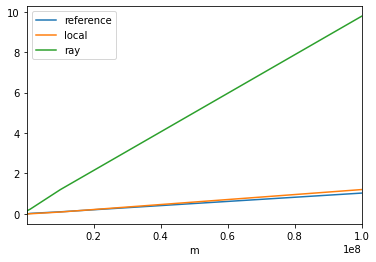

In [6]:
import pandas as pd
import time
from IPython.display import display


REFERENCE = lambda a, b: np.matmul(a, b)
LOCAL = lambda a, b: local_matmul(a, b)
RAY = lambda a, b: ray.get(par_matmul.remote(a, b))


def time_matmul(impl, l, m, n, trials=3):
    # not sure if this is a fair test (caching, background processes, etc)    
    times = []
    for _ in range(trials):  
        a = np.random.rand(l, m)
        b = np.random.rand(m, n)
        
        start_time = time.time()
        res = impl(a, b)
        runtime = time.time() - start_time
        times.append(runtime)
        
        expected = REFERENCE(a, b)
        np.testing.assert_allclose(res, expected)
    s = pd.Series(times)
    return s.mean(), s.std()

l = 5
n = 3
ms, ref_times, loc_times, ray_times = [], [], [], []
for m_exp in range(9):
    m = int(10**m_exp)
    ms.append(m)
    ref_mean, ref_std = time_matmul(REFERENCE, l, m, n)
    ref_times.append(ref_mean)
    loc_time, loc_std = time_matmul(LOCAL, l, m, n)
    loc_times.append(loc_time)
    ray_time, ray_std = time_matmul(RAY, l, m, n)
    ray_times.append(ray_time)

# oof
results = pd.DataFrame({'m': ms, 'reference': ref_times, 'local': loc_times, 'ray': ray_times})
results.plot(0)  
display(results)

## Stats

In [7]:
@ray.remote
class StreamingStats:
    def __init__(self):
        self.count = 0
        self.sum = 0
        self.squared_sum = 0
        
    def update(self, val):
        self.count += 1
        self.sum += val
        self.squared_sum += val * val
        
    def mean(self):
        return self.sum / self.count
    
    def std(self):
        return (abs(self.squared_sum / self.count - (self.sum / self.count) ** 2)) ** 0.5

In [8]:
s = StreamingStats.remote()

stream = np.random.rand(1000)
for val in stream:
    s.update.remote(val)
    
print(f'Expected: mean={stream.mean()}, std={stream.std()}')
print(f'Streaming: mean={ray.get(s.mean.remote())}, std={ray.get(s.std.remote())}')

Expected: mean=0.49958139824917963, std=0.2906121857594889
Streaming: mean=0.4995813982491802, std=0.2906121857594887


## Thompson Sampling

In [9]:
import collections


@ray.remote
class BetaBernoulliArm:
    def __init__(self, name='arm', alpha=1, beta=1, true_reward=0.5):
        assert alpha >= 1
        assert beta >= 1
        self.name = name
        self.alpha = alpha
        self.beta = beta
        self.true_reward = true_reward
        
    def name(self):
        return self.name
        
    def update_impression(self):
        # Pessimistic, immediate update encourages exploration
        self.beta += 1
        
    def update_conversion(self):
        self.alpha += 1
        self.beta += 1
        
    def empirical_mean(self):
        return self.alpha / (self.alpha + self.beta)
        
    def sample(self):
        return np.random.beta(self.alpha, self.beta)
    
    def outcome(self):
        return np.random.binomial(1, self.true_reward)

In [10]:
import collections
import pprint


def thompson_sample(arms):
    if not arms:
        return None
    
    sample_futures = np.array([arm.sample.remote() for arm in arms])
    best_sample, best_index = float('-inf'), 0
    for i, future in enumerate(sample_futures):
        sample = ray.get(future)
        if sample > best_sample:
            best_sample, best_index = sample, i
    return ray.get(arms[best_index].name.remote())

def exposures(arms, resolution=1e-3):
    trials = int(2 / resolution)
    counts = collections.defaultdict(int)
    for _ in range(trials):
        variant = thompson_sample(arms)
        counts[variant] += 1
    return counts

uniform_arm = BetaBernoulliArm.remote('uniform', 1, 1, 0.5)
good_arm = BetaBernoulliArm.remote('good', 80, 20, 0.85)
bad_arm = BetaBernoulliArm.remote('bad', 20, 80, 0.25)
promising_arm = BetaBernoulliArm.remote('promising', 9, 1, 0.99)
arms = [uniform_arm, good_arm, bad_arm, promising_arm]

exposures(arms)

defaultdict(int, {'promising': 1599, 'uniform': 159, 'good': 242})

Text(0, 0.5, 'reward')

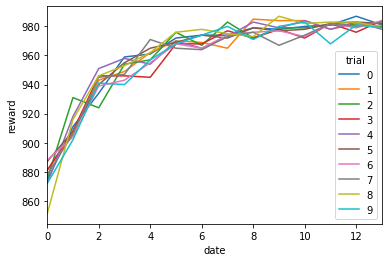

In [12]:
import pandas as pd


TRIALS = 10
EPISODE = 14
BATCH = 1000


@ray.remote
def simulate(trial, episodes, batches):
    uniform_arm = BetaBernoulliArm.remote('uniform', 1, 1, 0.5)
    good_arm = BetaBernoulliArm.remote('good', 80, 20, 0.85)
    bad_arm = BetaBernoulliArm.remote('bad', 20, 80, 0.25)
    promising_arm = BetaBernoulliArm.remote('great', 9, 1, 0.99)
    arm_list = [uniform_arm, good_arm, bad_arm, promising_arm]
    arms = {ray.get(arm.name.remote()): arm for arm in arm_list}
    
    dates = []
    conversions = []
    for episode in range(episodes):
        
        conversion = 0
        for batch in range(batches):
            arm = arms[thompson_sample(arm_list)]
            arm.update_impression.remote()
            if ray.get(arm.outcome.remote()):
                arm.update_conversion.remote()
                conversion += 1
        dates.append(episode)
        conversions.append(conversion)
    return pd.DataFrame({'trial': trial, 'date': dates, 'reward': conversions})


sim_ids = [simulate.remote(trial, EPISODE, BATCH) for trial in range(TRIALS)]
result_df = pd.concat([pd.DataFrame(ray.get(sim_id)) for sim_id in sim_ids])
ax = result_df.pivot(index='date', columns='trial', values='reward').plot()
ax.set_ylabel('reward')

In [ ]:
#restart_ray()